In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

def img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# Create a list with the filepaths
char_dir = Path('../input/the-simpsons-characters-dataset/simpsons_dataset')
filepaths = list(char_dir.glob(r'**/*.jpg'))

# Create a DataFrame with the filepaths and the labels of the picture
df = img(filepaths)

print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 41866

Number of different labels: 42

Labels: ['lisa_simpson' 'charles_montgomery_burns' 'marge_simpson' 'moe_szyslak'
 'bart_simpson' 'chief_wiggum' 'abraham_grampa_simpson' 'kent_brockman'
 'apu_nahasapeemapetilon' 'homer_simpson' 'principal_skinner' 'gil'
 'sideshow_bob' 'krusty_the_clown' 'milhouse_van_houten' 'edna_krabappel'
 'mayor_quimby' 'ned_flanders' 'nelson_muntz' 'maggie_simpson'
 'lenny_leonard' 'groundskeeper_willie' 'comic_book_guy' 'fat_tony'
 'martin_prince' 'barney_gumble' 'snake_jailbird' 'professor_john_frink'
 'waylon_smithers' 'carl_carlson' 'rainier_wolfcastle' 'sideshow_mel'
 'patty_bouvier' 'miss_hoover' 'ralph_wiggum' 'selma_bouvier'
 'agnes_skinner' 'cletus_spuckler' 'disco_stu' 'otto_mann' 'troy_mcclure'
 'lionel_hutz']


In [12]:
# Separate in train and test data
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=0.8, shuffle=True, random_state=0)

In [13]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [18]:
BATCH_SIZE = 32
EPOCHS = 16

In [19]:
train_images = train_generator.flow_from_dataframe(dataframe=train,
    x_col='Filepath',y_col='Label',target_size=(224, 224),
    color_mode='rgb',class_mode='categorical',
    batch_size=BATCH_SIZE,shuffle=True,
    subset='training',rotation_range=30,
    zoom_range=0.15,width_shift_range=0.2,
    height_shift_range=0.2,shear_range=0.15,
    horizontal_flip=True,fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train,x_col='Filepath',
    y_col='Label',target_size=(224, 224),
    color_mode='rgb',class_mode='categorical',
    batch_size=BATCH_SIZE, shuffle=True, subset='validation',
    rotation_range=30,zoom_range=0.15,width_shift_range=0.2,
    height_shift_range=0.2,shear_range=0.15,
    horizontal_flip=True,fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test,x_col='Filepath',
    y_col='Label',target_size=(224, 224),
    color_mode='rgb',class_mode='categorical',
    batch_size=BATCH_SIZE, shuffle=False
)

Found 26794 validated image filenames belonging to 42 classes.
Found 6698 validated image filenames belonging to 42 classes.
Found 8374 validated image filenames belonging to 42 classes.


## Training on prebuild model

In [20]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

#model training

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(42, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [21]:
history = model.fit(train_images,validation_data=val_images,epochs=EPOCHS)

Epoch 1/16
838/838 [==============================] - 291s 345ms/step - loss: 2.1381 - accuracy: 0.4382 - val_loss: 1.2023 - val_accuracy: 0.6742
Epoch 2/16
838/838 [==============================] - 125s 149ms/step - loss: 1.0322 - accuracy: 0.7181 - val_loss: 0.9609 - val_accuracy: 0.7329
Epoch 3/16
838/838 [==============================] - 125s 149ms/step - loss: 0.7633 - accuracy: 0.7861 - val_loss: 0.8472 - val_accuracy: 0.7660
Epoch 4/16
838/838 [==============================] - 125s 149ms/step - loss: 0.6069 - accuracy: 0.8249 - val_loss: 0.8361 - val_accuracy: 0.7713
Epoch 5/16
838/838 [==============================] - 127s 151ms/step - loss: 0.4778 - accuracy: 0.8622 - val_loss: 0.7518 - val_accuracy: 0.7943
Epoch 6/16
838/838 [==============================] - 124s 148ms/step - loss: 0.3875 - accuracy: 0.8880 - val_loss: 0.6657 - val_accuracy: 0.8252
Epoch 7/16
838/838 [==============================] - 125s 149ms/step - loss: 0.3059 - accuracy: 0.9084 - val_loss: 0.6707 -

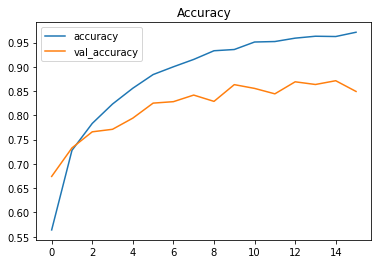

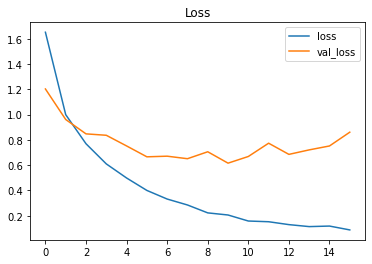

In [23]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

## Testing

In [66]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred, axis = -1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [67]:
from sklearn.metrics import accuracy_score
y_test = list(test.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 85.97%


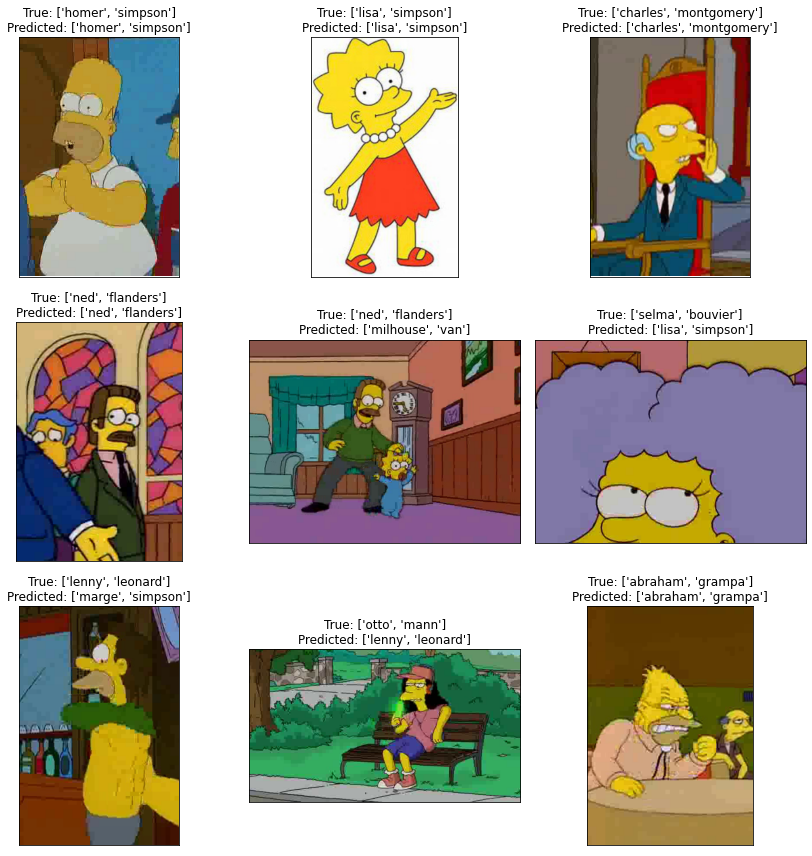

In [64]:
# Display pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i].split('_')[:2]}\nPredicted: {pred[i].split('_')[:2]}")
plt.tight_layout()
plt.show()